In [10]:
from qiskit import QuantumCircuit, Aer, execute, IBMQ, QuantumRegister
from qiskit.visualization import plot_histogram, plot_state_qsphere
import math
import numpy as np

# Error mitigation

### What is it made for ?
In a quantum circuit, measuring a qubit can introduce some errors.

The way we can model the noise induced by measurement is to consider that our measurement gates are giving us a perfect output (a bitstring among the $2^n$ possible , $n$ the amount of qubits) and that this perfect output is then perturbated by some noise.

We can represent the process of noise being introduced in the measurement like this : 
![noise in measurement](error_mitigation_ressource/error_mitigation.svg)

Now the goal of error mitigation is to add a correction part to the result : 
![noise in measurement and mitigation](error_mitigation_ressource/error_mitigation_full.svg)


### How does it work ?

We know that every bitstring being mesured from a quantum circuit is part of $\mathbb{C}^{2^n}$, thus the idea behind the error mitigation algorithm is to make a circuit that build every states $s \in \mathbb{C}^{2^n}$, measure it and put them in a mitigation matrix, which the inverse will be applied to every mesured bitstring.

It therefor should be understood that each simulator or real backend has its own mitigation matrix, and that this matrix should be computed multiple times, mostly on real backend, because of the way a real quantum processor evolves.

### Algorithm walk through

Lets take the example of $n=2$. Then the basis our measurements will be in (lets call it $E$) is $E = \{|00\rangle,|01\rangle,|10\rangle,|11\rangle\}$.

Before building the error mitigation matrix, we need to introduce measurement error in the perfect simulators that we will be using, to mimic the behavior of a real backend:

In [11]:
def get_noise(p):
    """
    Generates a NoiseModel object which applies an X gate to a qubit with probability p
    Input : p (float) the probability of applying an X gate
    Output : noise_model (qiskit.providers.aer.noise.NoiseModel) the noise model object that can be given to our simulator
    """
    from qiskit.providers.aer.noise import NoiseModel
    from qiskit.providers.aer.noise.errors import pauli_error
    error_meas = pauli_error([('X',p), ('I', 1 - p)]) #The pauli error is a class that applies the gates we gave it with the chances associated

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements

    return noise_model

noise_model = get_noise(0.01)#We introduce an X gate with probability 0.1

We can test our noise model on a simple circuit that should generate the state $|11\rangle$ :

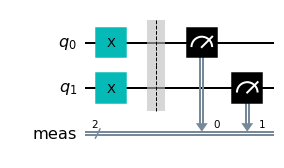

Probability distribution :  {'11': 1001, '01': 11, '10': 12}


In [12]:
qc = QuantumCircuit(2)
qc.x(range(2))
qc.measure_all()
display(qc.draw(output = 'mpl'))

backend = Aer.get_backend('qasm_simulator') #This simulator, as the other simulators, si perfect, so we will have to introduce our noise model that we made
job = execute(qc,backend, noise_model = noise_model) 
result = job.result()
print("Probability distribution : ",result.get_counts())

There we can observe the consequences of the noise. We mostly measure the right output, but we sometimes have noisy results.

We will now use a function part of the qiskit.ignis library (soon to be qiskit experiment) to generate all the circuits we need to generate every basis states $s \in \mathbb{C}^{2^n}$ : 


In [13]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
qr = QuantumRegister(2)#We create 2 quantum registers as our example is in C^4 
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

The circuits created are :

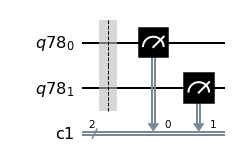

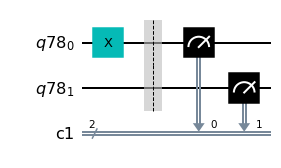

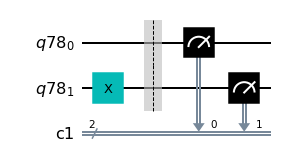

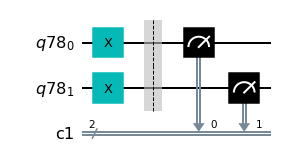

In [14]:
for circ in meas_calibs:
    display(circ.draw(output = 'mpl'))

Lets now execute our circuits and create the matrix using the CompleteMeasFitter function from qiskit.ignis :

In [15]:
job = execute(meas_calibs, backend, noise_model = noise_model)
result = job.result()#We are executing our circuits to have the distribution of the errors

meas_fitter = CompleteMeasFitter(result, state_labels, circlabel='mcal')#The results are fitted into a matrix
np.around(meas_fitter.cal_matrix,3)

array([[0.983, 0.015, 0.009, 0.   ],
       [0.01 , 0.979, 0.   , 0.015],
       [0.007, 0.   , 0.983, 0.016],
       [0.   , 0.006, 0.008, 0.97 ]])

Now that we have this matrix, we can use the following formula : 
Let $M$ be the error mitigation matrix, $C_{noisy}$ an output of a measurement of a circuit on the simulator and $C_{ideal}$ the expected output of the circuit.
Then we have the following ideal relation:
$$MC_{ideal} = C_{noisy}$$
In reality, given numerical errors and inconsistency of a real backend, the equations would look like : 
$$MC_{ideal} \approx C_{noisy}$$
So, when mesuring a quantum circuit, we want to apply the matrix $M^{-1}$ to it to allow the results to be closer to reality.

Let's see the example of trying to measure a Bell state : 

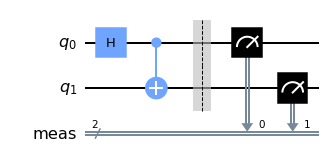

{'11': 404, '00': 417, '01': 98, '10': 105}

In [7]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.measure_all()
display(qc.draw(output = 'mpl')) #This circuit generates the bell state |+>

job = execute(qc,backend,noise_model = noise_model)
result = job.result()
result.get_counts()

As we can see, without error mitigation, we measure the right superposition most of the time, with errors.
To mitigate these errors, we could apply the matrix we computed above, but qiskit?ignis has a fitter for it, that use an optimized matrix inversion algorithm :

In [8]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(result)
mitigated_counts = mitigated_results.get_counts()

We can then plot the result of the correction to acknowledge the modification :

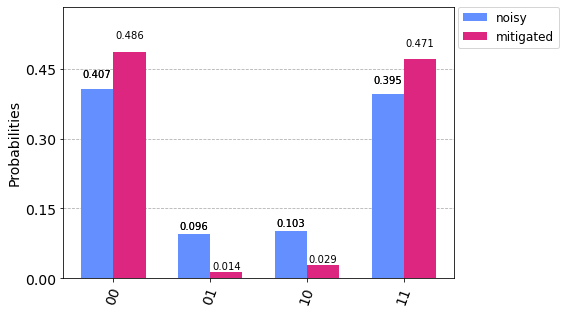

In [9]:
noisy_counts = result.get_counts()
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

Often the error will be reduced, sometimes even cancelled entierly